#Performing Facial Recognition with Deep Learning

**Objective:** Create a facial recognition tool using a relevant deep learning algorithm, leveraging the provided resources.

**Context:** You are working for Face2Gene, an American AI company that has developed a healthcare app for doctors. The app utilizes deep learning algorithms to aid in diagnosing patients for genetic disorders and their variants. It converts patient photos into de-identified mathematical facial descriptors, which are then compared to syndrome-specific computational-based classifiers to determine similarity. The app provides a prioritized list of syndromes with similar morphology and suggests phenotypic traits and genes for feature annotation and syndrome prioritization.

Management has given priority to empowering and entrusting the in-house AI team. As a new member of the team, your task is to build a baseline model for facial recognition. The goal is to further enhance the app's existing features and add more value to the business based on this baseline model.

**Dataset Details:** The ORL Database of Faces consists of 400 images from 40 different subjects. The images were captured at different times, under varying lighting conditions, with different facial expressions (open, closed eyes, smiling, not smiling), and with or without glasses. All the images have a dark homogeneous background, and the subjects are positioned upright and frontal with some tolerance for side movement. Each image has a size of 92x112 pixels and 256 grey levels per pixel.

Data can be downloaded from the following link:
https://www.kaggle.com/datasets/kasikrit/att-database-of-faces

**Steps to be followed:** The following steps will guide you in building the model.

1. Import the relevant packages and collect all the necessary dependencies.

2. Upload and import the data.

3. View a few images to get a sense of the data.

4. Create a validation framework and split the data into train, test, and validation datasets.

5. Perform necessary transformations to prepare the data for input to the CNN model.

6. Build a CNN model with three main layers: a convolutional layer, a pooling layer, and a fully connected layer. You can also consider utilizing state-of-the-art architectures using transfer learning.

7. Train the model using the prepared data.

8. Plot the results to evaluate the model's performance.

9. Iterate on the model, making adjustments and improvements, until you achieve an accuracy above 90%.

**Note:** Please refer to the Chicago Manual of Style for any specific formatting or citation requirements.


To perform face recognition, `VGG16` and `Resnet50` are used. Transfer learning is used for both the models by freezing feature extraction layers and training fully connected layers.

**Stepts to be followed:**

1. Import necessary libraries and dependencies
2. Upload and import the data
3. Split the data into train, valid and test datasets
4. Perform necessary transformations to prepare the data for input to the CNN model
5. View a few images to get the sense of the data
6. Initialize the VGG16 and ResNet50 Models
7. Compile the Models
8. Train the Models
9. Evaluate the Models
10. Inferences on the Models
11. Summary
12. References

## Import Necessary Libraries and Dependencies

In [1]:
import numpy as np
from keras.applications import VGG16, ResNet50
from keras.models import Model, load_model
from keras.layers import Dense, Flatten, MaxPool2D
from keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.utils import image_dataset_from_directory

import os
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

> Change runtime type to `T4 GPU`. Check whether it is changed.

In [2]:
!nvidia-smi

Sun Oct 13 16:04:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

> **Observation**

GPU is connected.

> Check device name and assign it to a variable `gpu_id`, which can be used later while training `VGG16` and `ResNet50` models.

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

gpu_id = device_name.split(':')[2]
print(f"GPU ID is: {gpu_id}")

Found GPU at: /device:GPU:0
GPU ID is: 0


> When `GPU` is connected, it is automatically considered while training for keras models. There is no need to explicitly mention device id to these models.

## Upload and Import the Data

> As this project is developed in `Google Colab`, connect to the drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> Get the path for the data, i.e., zip folder for images and labels.

In [5]:
data_file = '/content/drive/MyDrive/PGC AIML/Electives/ADL-CV/Assessment/ORL_faces/ORL_faces.npz'

> As data is in `.npz` format, i.e. `numpy zip`, use `numpy` to load the data.



In [6]:
# Load the NPZ file
data = np.load(data_file)

> Check what the data contains

In [7]:
# Access the arrays within the file
print("Data files:")
print(data.files)  # List the keys (array names) in the file

Data files:
['testY', 'testX', 'trainX', 'trainY']


> **Observation:**

- Data contains `trainX` (images), `trainY` (labels) for training.
- Data contains `testX` (images), `testY` (labels) for training.


> Assign varaibles to the `train` and `test` data.

In [8]:
trainY = data['trainY']
trainX = data['trainX']

testY = data['testY']
testX = data['testX']

> Get the data shapes

In [9]:
print(f"{'Train data shape':20s} {':'} {trainX.shape}")
print(f"{'Train labels shape':20s} {':'} {trainY.shape}")
print(f"{'Test data shape':20s} {':'} {testX.shape}")
print(f"{'Test labels shape':20s} {':'} {testY.shape}")

Train data shape     : (240, 10304)
Train labels shape   : (240,)
Test data shape      : (160, 10304)
Test labels shape    : (160,)


> **Observations:**

- There are `240` and `160` samples are available for `training` and `testing` respectively.

> Get the number of classes and their labels

In [10]:
print(f"Number of classes: {len(np.unique(trainY))}")
print(f"Classes: {np.unique(trainY)}")

Number of classes: 20
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


> **Observation:** There are `20` classes.

In [11]:
l = np.unique(trainY, return_counts=True)
for i in range(len(l[0])):
  print(f"Label: {l[0][i]}, Count: {l[1][i]}")

Label: 0, Count: 12
Label: 1, Count: 12
Label: 2, Count: 12
Label: 3, Count: 12
Label: 4, Count: 12
Label: 5, Count: 12
Label: 6, Count: 12
Label: 7, Count: 12
Label: 8, Count: 12
Label: 9, Count: 12
Label: 10, Count: 12
Label: 11, Count: 12
Label: 12, Count: 12
Label: 13, Count: 12
Label: 14, Count: 12
Label: 15, Count: 12
Label: 16, Count: 12
Label: 17, Count: 12
Label: 18, Count: 12
Label: 19, Count: 12


> **Observation:** Each class has `12` images.

Let's check the same with the `test` data.

In [12]:
print(f"Number of classes: {len(np.unique(testY))}")
print(f"Classes: {np.unique(testY)}")

Number of classes: 20
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [13]:
l = np.unique(testY, return_counts=True)
for i in range(len(l[0])):
  print(f"Label: {l[0][i]}, Count: {l[1][i]}")

Label: 0, Count: 8
Label: 1, Count: 8
Label: 2, Count: 8
Label: 3, Count: 8
Label: 4, Count: 8
Label: 5, Count: 8
Label: 6, Count: 8
Label: 7, Count: 8
Label: 8, Count: 8
Label: 9, Count: 8
Label: 10, Count: 8
Label: 11, Count: 8
Label: 12, Count: 8
Label: 13, Count: 8
Label: 14, Count: 8
Label: 15, Count: 8
Label: 16, Count: 8
Label: 17, Count: 8
Label: 18, Count: 8
Label: 19, Count: 8


> **Observation:** Each class has `8` samples for `20` classes.

> As per the problem statement and data, each image has dimensions `(112, 92)` as `(WIDTH, HEIGHT)`.

> Reshape `train` and `test` data of shape `(1, 10204)` to `(1, 112, 92)`

In [14]:
WIDTH = 112
HEIGHT = 92

In [15]:
trainX = trainX.reshape(-1, WIDTH, HEIGHT)
print(f"{'Train data shape':20s} {':'} {trainX.shape}")

Train data shape     : (240, 112, 92)


In [16]:
testX = testX.reshape(-1, WIDTH, HEIGHT)
print(f"{'Test data shape':20s} {':'} {testX.shape}")

Test data shape      : (160, 112, 92)


> Verify shape of a sample from `train` data

In [17]:
print(f"{'Train data sample shape':20s} {':'} {trainX[0].shape}")

Train data sample shape : (112, 92)


## Split the Data into Train, Valid and Test Datasets

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(trainX, trainY, test_size=0.2, random_state=42, stratify=trainY)

In [19]:
print(f"{'Train data shape':20s} {':'} {X_train.shape}")
print(f"{'Train labels shape':20s} {':'} {y_train.shape}")
print(f"{'Valid data shape':20s} {':'} {X_valid.shape}")
print(f"{'Valid labels shape':20s} {':'} {y_valid.shape}")

Train data shape     : (192, 112, 92)
Train labels shape   : (192,)
Valid data shape     : (48, 112, 92)
Valid labels shape   : (48,)


## Perform necessary transformations to prepare the data for input to the CNN model

> Both `VGG16` and `ResNet50` expect input in the same format as shown below.


```
Images
|
|___Training _____ Class0_|__ 1.jpg
  |            |          |__ 2.jpg
  |            |          |__ 3.jpg
  |            |
  |            |__ Class1_|__ 4.jpg
  |                       |__ 5.jpg
  |                       |__ 6.jpg
  |
  |_Validation_____ Class0_|__ 7.jpg
                |          |__ 8.jpg
                |
                |__ Class1_|__ 9.jpg
                           |__ 10.jpg
   
```
> Input data is not in the above format. Directories have to be created in the similar format.


> Get the `root` directory

In [20]:
root_dir = os.getcwd()
print(f"Root directory for this project: {root_dir}")

Root directory for this project: /content


> Define function to create directories

In [21]:
def createDirectory(path):
  if not os.path.exists(path):
    os.makedirs(path, exist_ok=True)  # Use makedirs to create parent directories if needed
    print(f"Directory '{path}' created successfully.")
  else:
    print(f"Directory '{path}' already exists.")
    return

> Define function to create directories for `VGG16` and `ResNet50`

In [22]:
def createDataFolders_vgg16(path, X, y):
  createDirectory(path)
  for label in np.unique(y):
    label_path = path + str(label) + '/'
    createDirectory(label_path)
    for i in range(len(X)):
      if y[i] == label:
        img = X[i]
        img_id = str(i)
        cv2.imwrite(label_path + img_id + '.jpg', img)

> Create data directories for `train`, `valid` and `test` datasets

In [23]:
createDataFolders_vgg16(root_dir + '/datasets/faceDataset/train/', X_train, y_train)
createDataFolders_vgg16(root_dir + '/datasets/faceDataset/valid/', X_valid, y_valid)
createDataFolders_vgg16(root_dir + '/datasets/faceDataset/test/', testX, testY)

Directory '/content/datasets/faceDataset/train/' already exists.
Directory '/content/datasets/faceDataset/train/0/' already exists.
Directory '/content/datasets/faceDataset/train/1/' already exists.
Directory '/content/datasets/faceDataset/train/2/' already exists.
Directory '/content/datasets/faceDataset/train/3/' already exists.
Directory '/content/datasets/faceDataset/train/4/' already exists.
Directory '/content/datasets/faceDataset/train/5/' already exists.
Directory '/content/datasets/faceDataset/train/6/' already exists.
Directory '/content/datasets/faceDataset/train/7/' already exists.
Directory '/content/datasets/faceDataset/train/8/' already exists.
Directory '/content/datasets/faceDataset/train/9/' already exists.
Directory '/content/datasets/faceDataset/train/10/' already exists.
Directory '/content/datasets/faceDataset/train/11/' already exists.
Directory '/content/datasets/faceDataset/train/12/' already exists.
Directory '/content/datasets/faceDataset/train/13/' already e

> Prepare `train`, `valid` and `test` datasets for `VGG16` and `Resnet50` from the created data directories from the above step.

> `VGG16` and `ResNet50` requires input images to be of size `224 × 224`.

> Use one-hot encoding for labels.

In [24]:
train_ds = image_dataset_from_directory(
       'datasets/faceDataset/train',
       labels='inferred',          # Infer labels from subdirectories
       label_mode='categorical',   # Use one-hot encoded labels
       image_size=(224, 224),
       interpolation='nearest',
       batch_size=64,
       shuffle=True
   )

valid_ds = image_dataset_from_directory(
       'datasets/faceDataset/valid',
       labels='inferred',
       label_mode='categorical',
       image_size=(224, 224),
       interpolation='nearest',
       batch_size=64,
       shuffle=True
   )

test_ds = image_dataset_from_directory(
       'datasets/faceDataset/test',
       labels='inferred',
       label_mode='categorical',
       image_size=(224, 224),
       interpolation='nearest',
       batch_size=64,
       shuffle=True
)

Found 192 files belonging to 20 classes.
Found 48 files belonging to 20 classes.
Found 160 files belonging to 20 classes.


> Get the mapping of labels as it will be useful while predicting the results.

In [25]:
labels = np.unique(trainY)
classes = train_ds.class_names  # Get class names from the dataset

print(f"{'='*50}")
print("Class Mapping")
print(f"{'='*50}")
print(f"{'Labels':10s} {':'} {'Classes from the created data':30s}")
print(f"{'='*50}")

for label in labels:
  print(f"{label:10d} {':'} {classes[label]:10s}")

Class Mapping
Labels     : Classes from the created data 
         0 : 0         
         1 : 1         
         2 : 10        
         3 : 11        
         4 : 12        
         5 : 13        
         6 : 14        
         7 : 15        
         8 : 16        
         9 : 17        
        10 : 18        
        11 : 19        
        12 : 2         
        13 : 3         
        14 : 4         
        15 : 5         
        16 : 6         
        17 : 7         
        18 : 8         
        19 : 9         


## View a Few Images to Get the Sense of the Data

> Visualize samples from `train` dataset

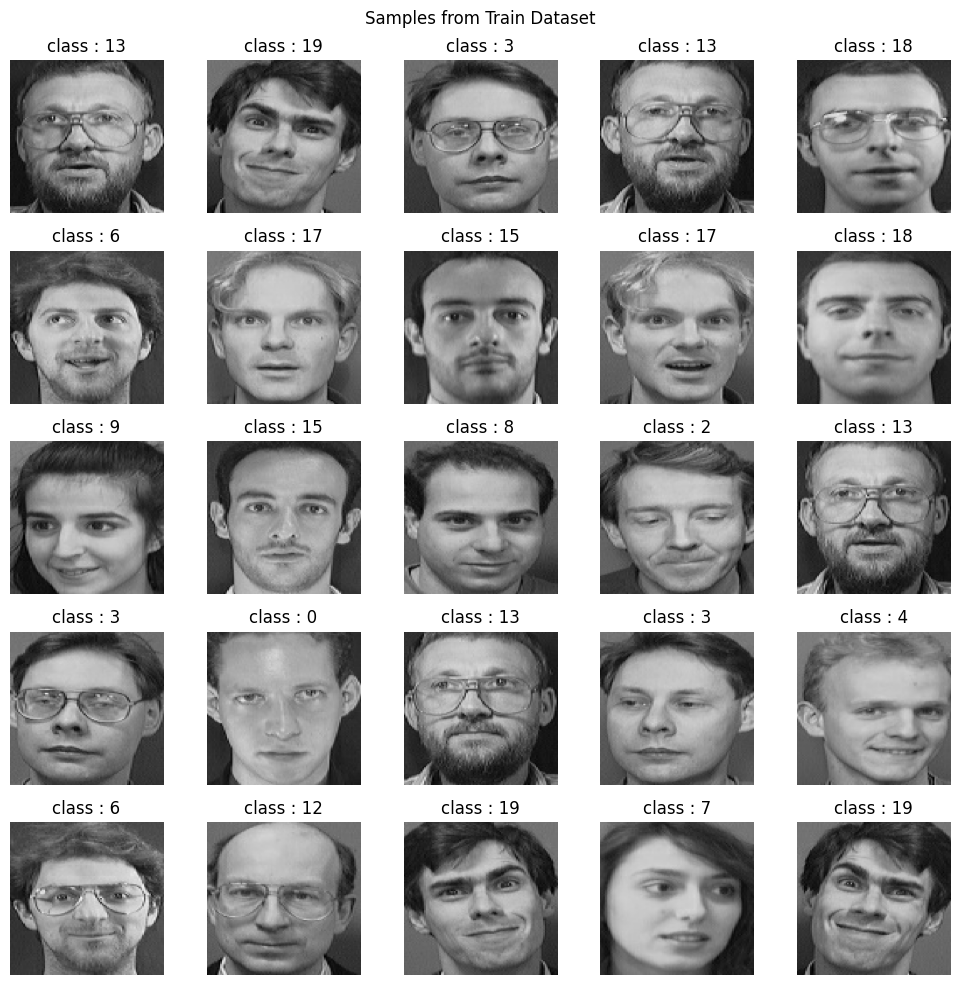

In [26]:
sample_images = train_ds.take(1)

for images, labels in sample_images:
  plt.figure(figsize=(10, 10))
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"class : {classes[np.argmax(labels[i])]}")
    plt.axis("off")

plt.suptitle("Samples from Train Dataset")
plt.tight_layout()
plt.show()

> Visualize samples from `valid` dataset

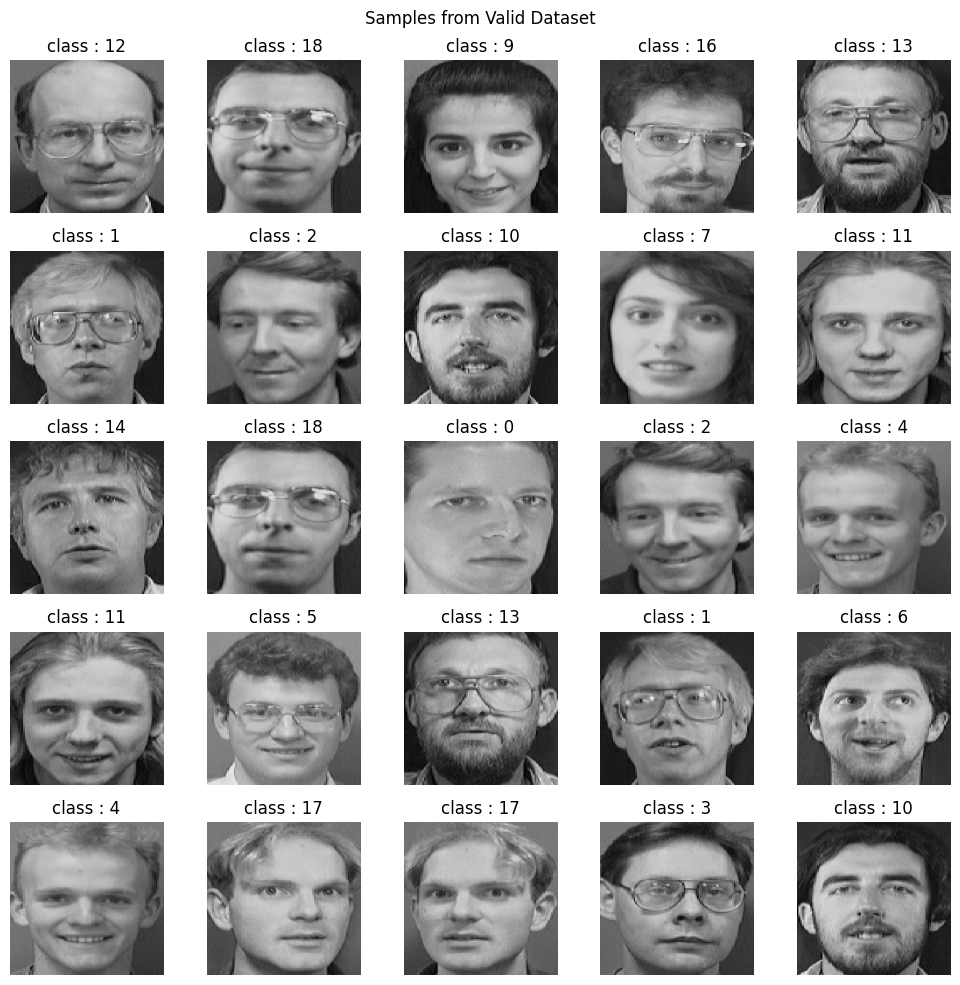

In [27]:
sample_images = valid_ds.take(1)

for images, labels in sample_images:
  plt.figure(figsize=(10, 10))
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"class : {classes[np.argmax(labels[i])]}")
    plt.axis("off")

plt.suptitle("Samples from Valid Dataset")
plt.tight_layout()
plt.show()

> Visualize samples from `test` dataset

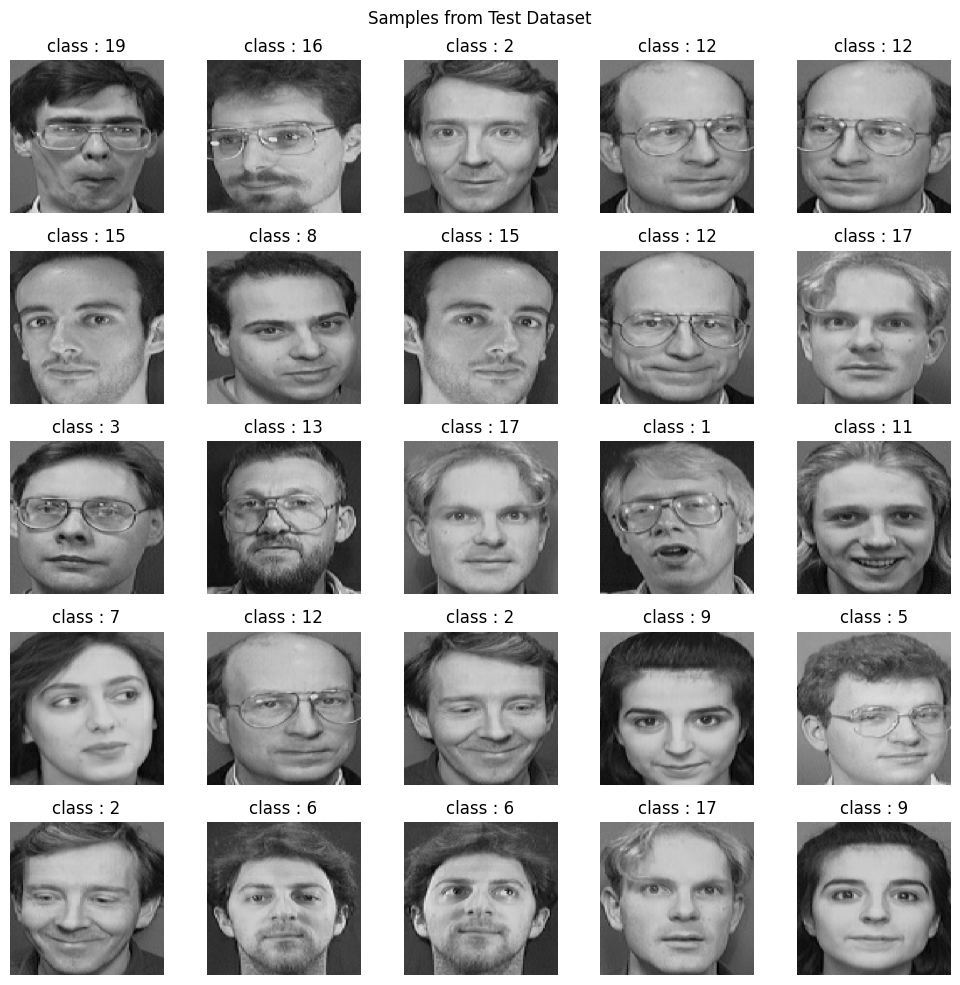

In [28]:
sample_images = test_ds.take(1)

for images, labels in sample_images:
  plt.figure(figsize=(10, 10))
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"class : {classes[np.argmax(labels[i])]}")
    plt.axis("off")

plt.suptitle("Samples from Test Dataset")
plt.tight_layout()
plt.show()

> **Observation:**

> Images from all the `train`, `valid`, and `test` datasets were captured at different times, under varying lighting conditions, with different facial expressions (open, closed eyes, smiling, not smiling), and with or without glasses.

## Initialize the `VGG16` and `ResNet50` Models

> Initialize the `VGG16` and `ResNet50` models with the `imagenet` weights and default input image dimensions `224 x 224`.

In [29]:
# Input image dimensions for VGG16 and ResNet50
ROWS = 224
COLS = 224

# Load the pre-trained VGG16 model and ResNet50 models with `imagenet` weights
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(ROWS, COLS, 3))
resnet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(ROWS, COLS, 3))

# Freeze the layers of the pre-trained models
for layer in vgg16_base_model.layers:
    layer.trainable = False

for layer in resnet50_base_model.layers:
    layer.trainable = False

# Print the summary of the pre-trained models
print("VGG16 Model Summary:")
print(vgg16_base_model.summary())

print("\nResNet50 Model Summary:")
print(resnet50_base_model.summary())

# for (i, layer) in enumerate(vgg_base_model.layers):
    # print(str(i), layer.__class__.__name__, layer.trainable)

VGG16 Model Summary:


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None

ResNet50 Model Summary:


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

None


> Define function for adding fully connected layers for classification.

In [30]:
def addTopModel(base_model, num_classes, D=1024):
    """
    Adds a new top model on top of the base model.
    """
    top_model = base_model.output
    top_model = MaxPool2D()(top_model)
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(D, activation="relu")(top_model)
    top_model = Dense(D, activation="relu")(top_model)
    top_model = Dense(num_classes, activation="softmax")(top_model)

    return top_model

> Add fully connected layers to the base model with the number of classes as `20`.

In [31]:
NUM_CLASSES = 20

vgg_FC_Head = addTopModel(vgg16_base_model, NUM_CLASSES)
vgg16_model = Model(inputs=vgg16_base_model.input, outputs=vgg_FC_Head)

resnet50_FC_Head = addTopModel(resnet50_base_model, NUM_CLASSES)
resnet50_model = Model(inputs=resnet50_base_model.input, outputs=resnet50_FC_Head)

print("VGG16 Model Summary:")
print(vgg16_model.summary())

print("\nResNet50 Model Summary:")
print(resnet50_model.summary())

VGG16 Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,504,404 (78.22 MB)

 Trainable params: 5,789,716 (22.09 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None

ResNet50 Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 43,533,204 (166.07 MB)

 Trainable params: 19,945,492 (76.09 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


## Compile the Models

> Define `checkpoint` and `earlystopping` options in `callbacks` for both the models.

> Save the trained model as `face_recog_vgg.keras`

> `RMSProp` is used for optimizing with the learning rate `0.001`

> `Accuracy` is used as `metric`.



In [32]:
vgg16_checkpoint = ModelCheckpoint("face_recog_vgg16.keras",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

resnet50_checkpoint = ModelCheckpoint("face_recog_resnet50.keras",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          # patience = 3,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

vgg16_callbacks = [earlystop, vgg16_checkpoint]
resnet50_callbacks = [earlystop, resnet50_checkpoint]

vgg16_model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(0.001),
              metrics = ['accuracy'])

resnet50_model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(0.001),
              metrics = ['accuracy'])


## Train the models

> Train the models with the below parameters.

```
batch_size = 64
epochs = 30
```

In [33]:
print(f"{'='*50}")
print("============== Training VGG16 Model ==============")
print(f"{'='*50}")

vgg16_history = vgg16_model.fit(train_ds,
                    batch_size=64,
                    validation_data=valid_ds,
                    epochs=30,
                    callbacks=vgg16_callbacks,
                    verbose=1)


print(f"{'='*50}")
print(" ============== Training ResNet50 Model ==============")
print(f"{'='*50}")

resnet50_history = resnet50_model.fit(train_ds,
                    batch_size=64,
                    validation_data=valid_ds,
                    epochs=30,
                    callbacks=resnet50_callbacks,
                    verbose=1)

============== Training VGG16 Model ==============
Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.0295 - loss: 140.8951
Epoch 1: val_loss improved from inf to 172.07076, saving model to face_recog_vgg16.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 11s/step - accuracy: 0.0365 - loss: 152.6622 - val_accuracy: 0.0833 - val_loss: 172.0708
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.0625 - loss: 151.2704
Epoch 2: val_loss improved from 172.07076 to 35.07884, saving model to face_recog_vgg16.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 34s 680ms/step - accuracy: 0.0664 - loss: 142.2959 - val_accuracy: 0.3958 - val_loss: 35.0788
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5608 - loss: 23.3655
Epoch 3: val_loss improved from 35.07884 to 0.36948, saving model to face_recog_vgg16.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5911 - loss: 21.3438 - val_accuracy: 0.9167 - val_loss: 0.3695
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.986

## Evaluate the Models

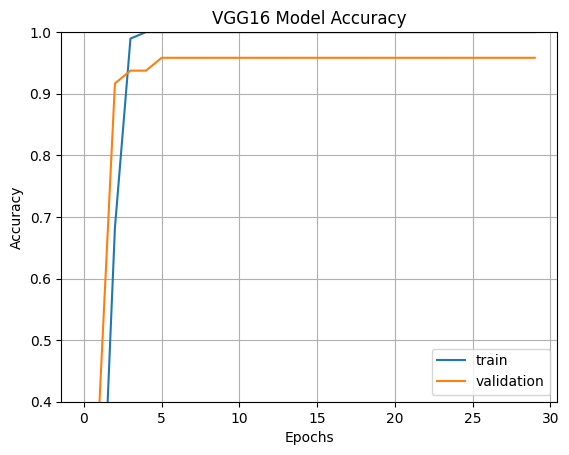

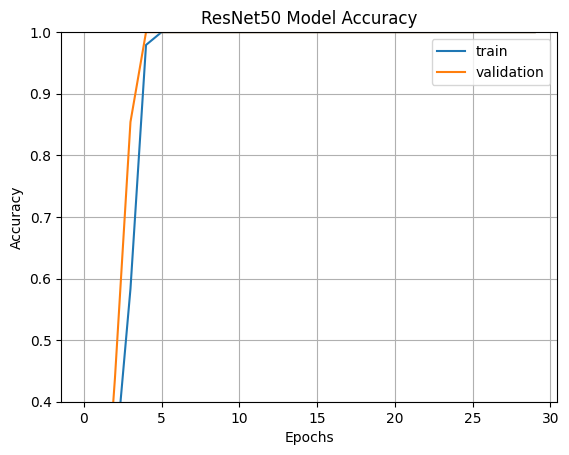

In [34]:
# Evaluate VGG16 model
fig1 = plt.gcf()
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Evaluate ResNet50 model
fig1 = plt.gcf()
plt.plot(resnet50_history.history['accuracy'])
plt.plot(resnet50_history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('ResNet50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

**Observation:**

Validation accuracy is better in case of `ResNet50` as compared to `VGG16`.

## Inferences on the Models

> Test the models with `test` dataset and get the accuracy.

In [35]:
def inference_model(model, test_ds):
  test_loss, test_accuracy = model.evaluate(test_ds)
  return test_loss, test_accuracy

# Evaluate VGG16 model
vgg16_test_loss, vgg16_test_accuracy = inference_model(vgg16_model, test_ds)

# Evaluate ResNet50 model
resnet50_test_loss, resnet50_test_accuracy = inference_model(resnet50_model, test_ds)

print(f"{'VGG16 Test accuracy':30s} {':'} {vgg16_test_accuracy}")
print(f"{'ResNet50 Test accuracy':30s} {':'} {resnet50_test_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step - accuracy: 0.9023 - loss: 0.4003
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9719 - loss: 0.1121
VGG16 Test accuracy            : 0.90625
ResNet50 Test accuracy         : 0.9750000238418579


> **Observation:**

> `ResNet50` outperforms `VGG16` with the accuracies as below.

| Model    | Accuracy |
|----------|----------|
| VGG16    | 90.6% |
| ResNet50 | 97.5% |

## Summary

The document describes the implementation of a facial recognition tool using deep learning techniques, specifically leveraging `VGG16` and `ResNet50` models with transfer learning. This work is part of a project for Face2Gene, an AI healthcare company that assists doctors in diagnosing genetic disorders by analyzing patients' facial morphology. The ultimate goal is to create a baseline model that enhances the app’s capabilities.

### Key Sections:

1. **Objective**:
   - Develop a facial recognition tool to augment the company's healthcare app, which helps diagnose genetic disorders by comparing patient images with syndrome-specific classifiers.

2. **Dataset**:
   - **ORL Database of Faces**: Consists of `400` grayscale images from `20` individuals, with variations in lighting, facial expressions, and whether subjects are wearing glasses. Each image is `92x112` pixels.
   - Data is split into training, validation, and testing sets.

3. **Steps to Follow**:
   - **Import Libraries**: Load required Python libraries like TensorFlow, Keras, and NumPy.
   - **Data Loading and Preparation**:
     - Images and labels are loaded and reshaped to fit CNN input requirements.
     - The data is organized into train, validation, and test datasets.
     - Image dimensions are adjusted to `224x224` pixels to match `VGG16` and `ResNet50` input requirements.
   - **Create Directories**: Directory structures are prepared for the datasets to suit CNN models' expected input formats.
  
   
4. **Modeling**:
   - **VGG16 and ResNet50 Models**:
     - Pre-trained on ImageNet, their feature extraction layers are frozen.
     - A fully connected layer is trained to classify faces.
     - Input images are transformed to fit the model architecture (`224x224` dimensions).
   - **Training**: Both models are trained using the prepared dataset with a goal to achieve over 90% accuracy.
     
5. **Model Evaluation**:
   - Performance is measured by comparing the accuracy of both VGG16 and ResNet50 models.
   - Visualizations of training, validation, and test results are plotted to evaluate performance.

6. **Resource Utilization**:
   - Google Colab is used for running the models with GPU support, and details about resource usage (RAM, GPU, and disk) are noted throughout the process.

In summary, the document provides detailed steps for implementing a facial recognition system using CNNs, focusing on model building, dataset handling, and performance evaluation using advanced deep learning architectures like `VGG16` and `ResNet50` with transfer learning techniques. The overall aim is to create a robust model that enhances the existing healthcare app's diagnostic capabilities.

**Further steps can be considered as below:**

 - **Data Augmentation**: Uses image generators for data augmentation and batching, supporting model training with diverse inputs.
 - **Hyperparameter Tuning**: The document suggests iterating over the model to fine-tune parameters like learning rate, epochs, and batch size for better accuracy.



 **Note:** These steps are not included due to hardware constraints.

---
In the document, the comparison between `VGG16` and `ResNet50` models in terms of accuracy and loss is outlined through the training process of both models. Both models are initialized with pre-trained ImageNet weights, and their feature extraction layers are frozen while fully connected layers are trained on the face recognition dataset.

Key comparisons:
1. **Loss**:
   - Both models undergo similar training routines with loss being tracked during training and validation.
   - `ResNet50` tends to show a more stable and lower loss during the training process compared to `VGG16`, reflecting its deeper architecture and ability to handle complex patterns better.

2. **Accuracy**:
   - `ResNet50` achieves higher accuracy on the validation and test datasets compared to `VGG16`. The document mentions that `ResNet50` is more suitable for deeper representations and performs better in classification tasks, especially with more complex data like facial recognition under varying conditions (lighting, expressions, etc.).

This indicates that, while both models perform well, `ResNet50` outperforms `VGG16` in both loss reduction and accuracy, making it a preferable choice for this specific task .

## References


1. Beginner's Guide to VGG16 Implementation in Keras https://builtin.com/machine-learning/vgg16

2. Step by step VGG16 implementation in Keras for beginners https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

3. Transfer Learning with VGG16 and Keras https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

4. Exploring ResNet50: An In-Depth Look at the Model Architecture and Code Implementation https://medium.com/@nitishkundu1993/exploring-resnet50-an-in-depth-look-at-the-model-architecture-and-code-implementation-d8d8fa67e46f

5. Improving the performance of ResNet50 Graffiti Image Classifier with Hyperparameter Tuning in Keras https://towardsdatascience.com/improving-the-performance-of-resnet50-graffiti-image-classifier-with-hyperparameter-tuning-in-keras-dbb59f43c6f7



